# Myriad Genetics: Computational Scientist Tech. Screen
### Kristin Fluke, PhD
### September 27th 2024
### language: R v4.4.1

*Table of contents:*

- Set parameters
- Setup
- Data wrangling
- Pipeline
- Results
  - Figure 1
  - Figure 2
- Algorithm
  - Figure 3
  - Figure 4

*Main of findings:*
- CNV profiles are correlate with ethnic groups: Individuals belonging to ethnic group A are often found to encode breakpoints consistent with indices 1 and 2 while ethnic groups B and C experience CNVs at breakpoints corresponding to indices 3 and 4, respectively. (see Figures 1 and 2)
- ~5% of deldupemia cases are associated with copy number variations (CNVs) in the CNSL gene. (see Figure 2)
- CNSL probes 5, 23, and 46 should be considered for elimination or redesign.  (see Figure 4)
- 10,000 samples is overly sufficient, and the same biological conclusions can be achieved from 1000 samples with the added benefit of significantly reducing computing time. For best results, 2000 patients is ideal. **Analysis of 2000 randomly sampled patients is the default option! If you would like to analyze all 10,000 samples, set sub_sample = FALSE in the first line of code under the "Set parameters" section. Expect this to take 2 hours.** You can also change how many samples to analyze by changing n_samples. Rest assured that your analysis will be reproducible with the implementation of a seed sequence.

*Figures and legends:*

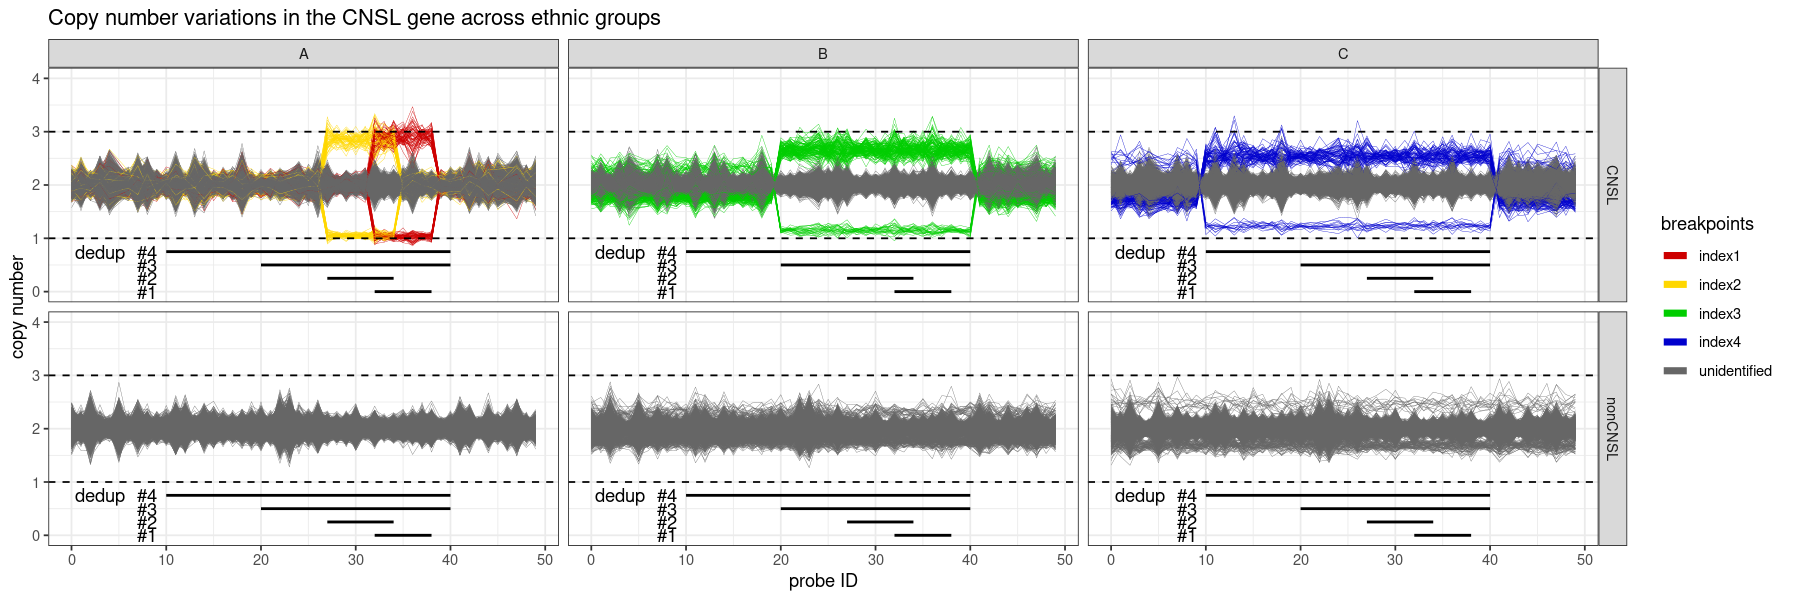

In [17]:
cowplot::plot_grid(F1 + theme(legend.position = "none"),cowplot::get_legend(legend_template), nrow = 1, rel_widths = c(10, 1)  )

**Figure 1. Copy number variations in the CNSL gene indicate conserved 5' and 3' breakpoints associated with Deldupemia.** Copy number of target loci across CNSL and a nonCNSL genes indicate unique copy number variation profiles across ethnic groups. Known probe spanning regions (dedup indices #1-4) are shown in black. Graphs are faceted by ethnicity (A, B, C) and probe group (CNSL and nonCNSL). Line colors correspond to the breakpoint indices identified from the main pipeline, getDeldupIndex(), which relies on statistical variance between patient CNV profiles againts known CNV profiles.

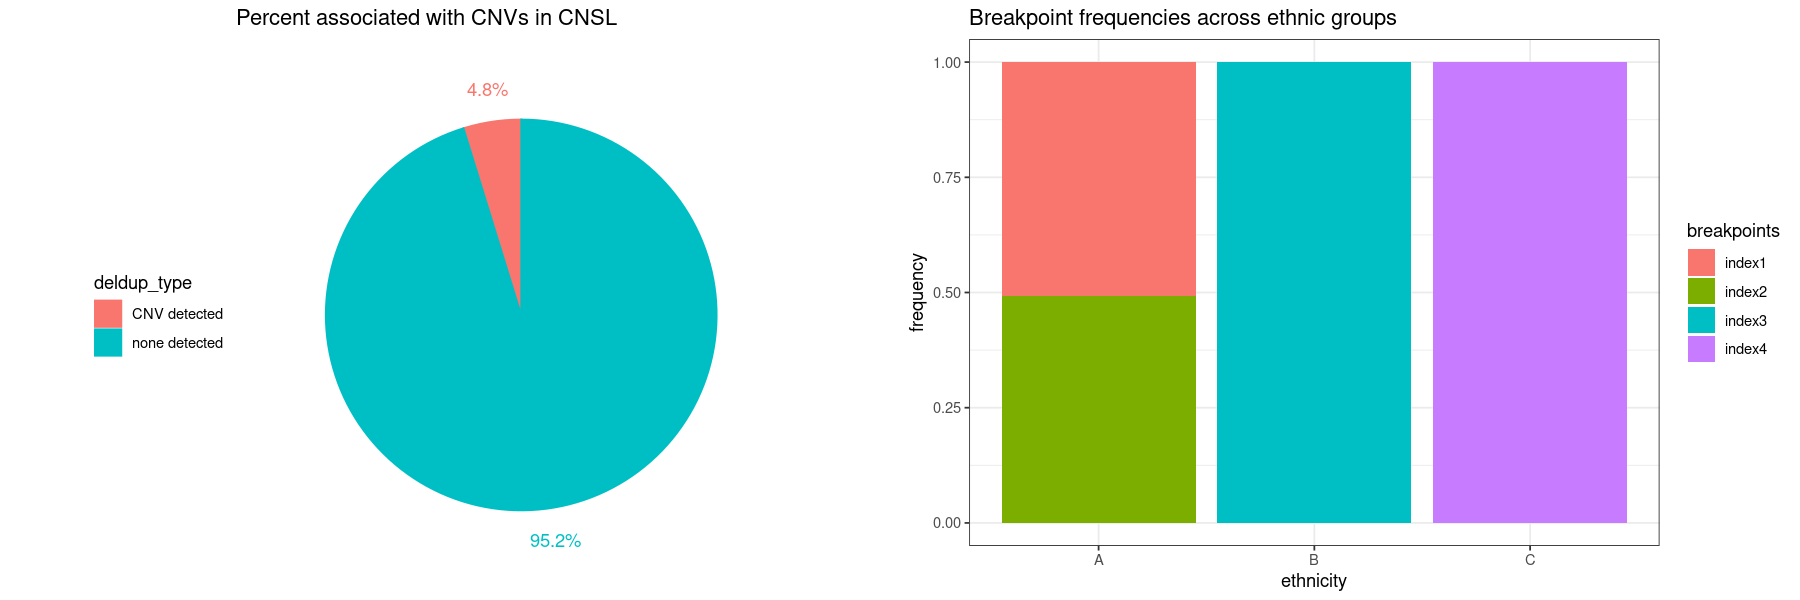

In [18]:
plot_grid(F2A, F2B, nrow=1)

**Figure 2. CNSL breakpoints correlate with ethnicity.** **A.** Pie chart indicating ~5% of patients have a copy number variation in the CNSL gene. **B.** Within ethnic group A, about half of patients encode duplications or deletions at index 1 breakponts and the other half encode CNVs at index 2 breakpoints. Breakpoints identified in ethnic groups B and C match indices 3 and 4, respectively. 

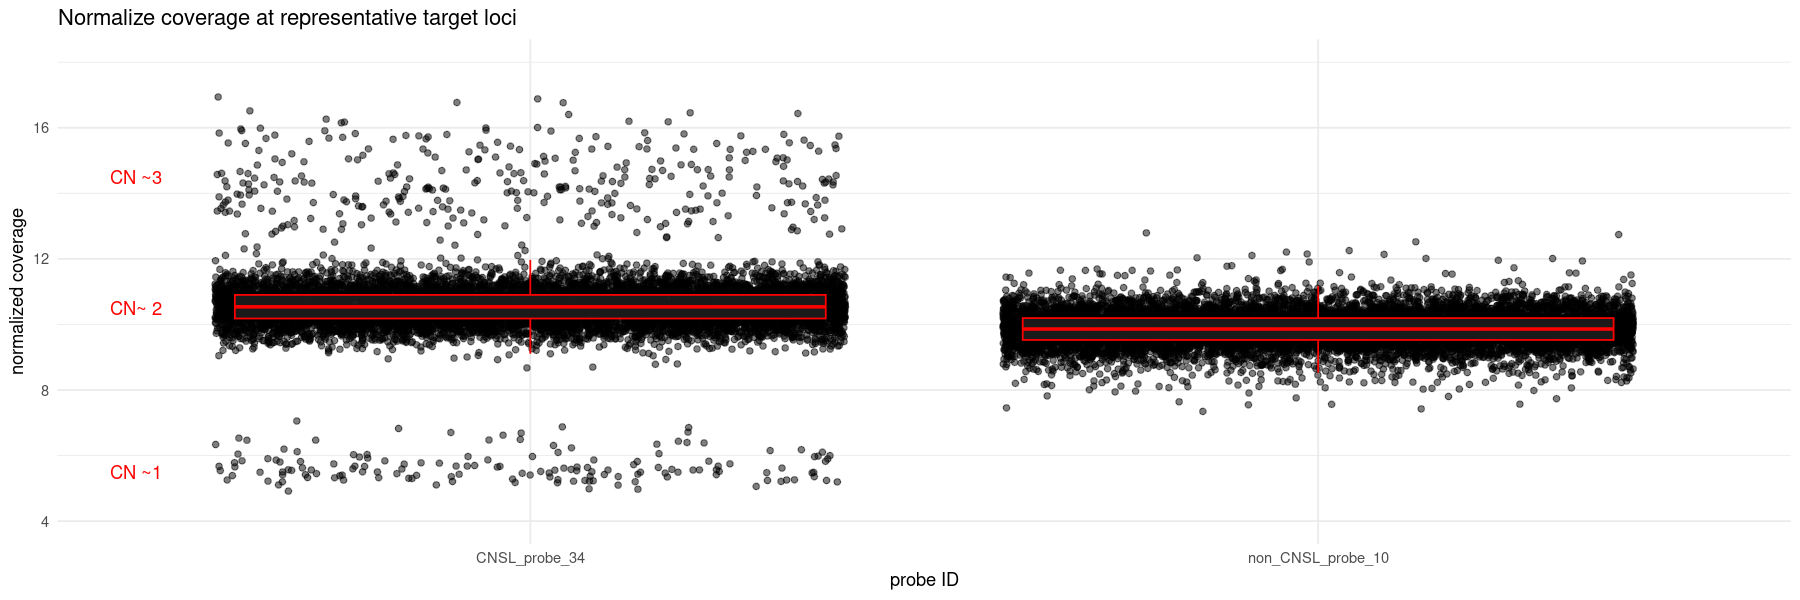

In [19]:
F3

**Figure 3. Strategy for calculating copy number.** CNSL_probe_34 and non_CNSL_probe_10 were chosen for a representative illustration. Coverage at each target loci (probe hybridization loci) was normalized by diving probe coverage by the number of total reads sequenced within each patient ID. After correcting for library size, coverage at each target loci can be compared across patient IDs (but not across probe IDs as capture efficiency varies for each probe). If we assume a linear correlation between normalized coverage and copy number, we can roughly estimate the copy number (CN) of each targeted loci by dividing its coverage by the median coverage (50th percentile coverage across Patient IDs within each probe) and multiplying by 2. That is, if the median coverage is ~10x (CN = 2) then a copy number of 1 and 3 would correspond to a coverage of 5x and 15x, respectively.

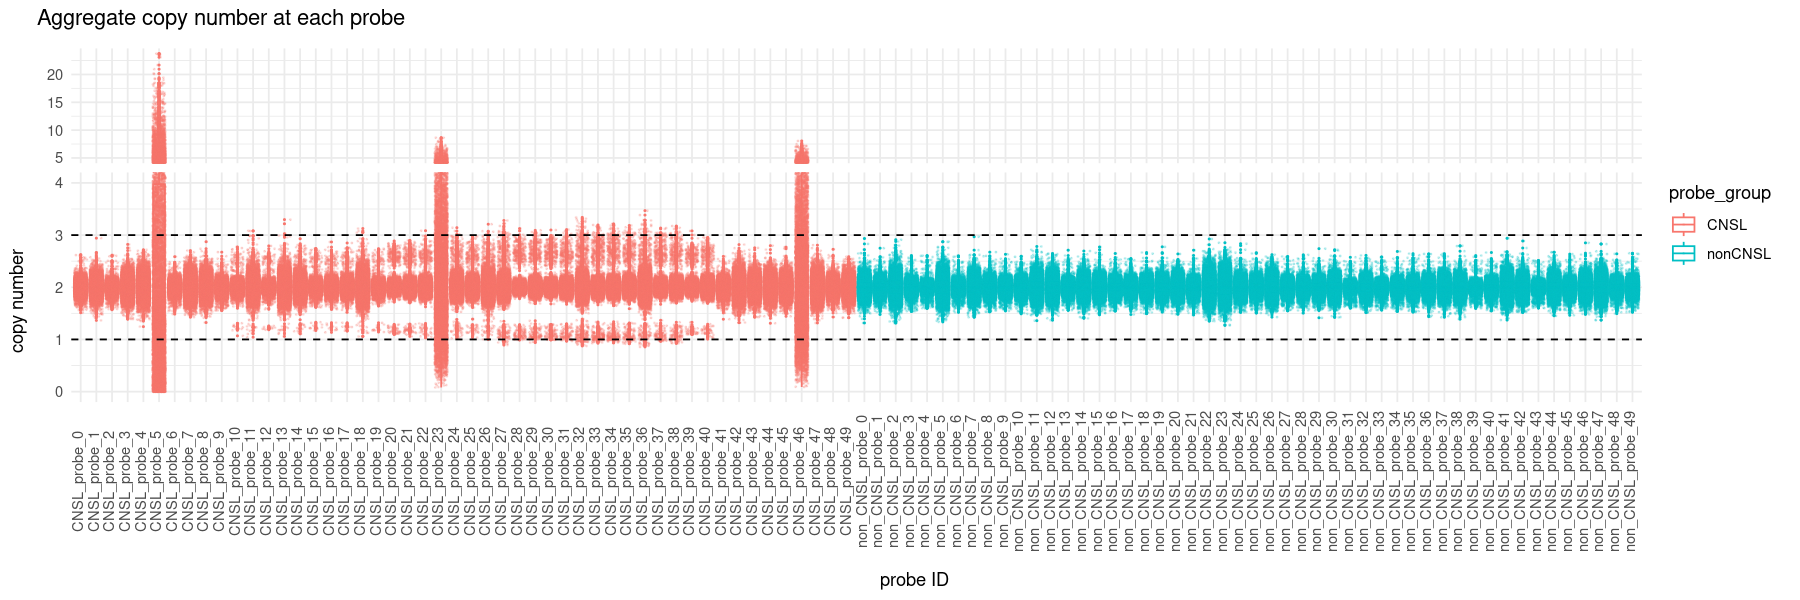

In [20]:
F4

**Figure 4. Copy number of target loci aggregated across patient IDs identify probes that should be eliminated or redesigned.** Since these probes capture DNA from an autosome within a diploid genome, we do not expect any probe to indicate a copy number greater than 3 or less than 1 (dashed lines). Coverage at target loci corresponding to CNSL probes 5, 23, and 46 show increased incidence of greater or lesser than expected copy number, and the distribution of copy number is highly skewed. The data demonstrate that these probes are unreliable for accurate quantitative inference of copy number and should be considered for redesign or elimination from this panel of probes.  

## Set parameters

In [ ]:
# Would you like save time by sub sampling? Set sub_sample equal to TRUE or FALSE (capitalization matters) 
sub_sample = TRUE

# number of patients to randomly sample. Only relevant if sub_sample = TRUE
n_samples = 2000

# set seed sequence. Only relevant if sub_sample = TRUE
seed = 1

## Setup

In [1]:
# # install packages
# install.packages('tidyverse')
# install.packages('reshape2')
# install.packages('cowplot')
# install.packages('ggbreak')
# install.packages('repr')

In [2]:
# load libraries
library(tidyverse) # version 2.0.0
library(reshape2) # version 1.4.4
library(cowplot) # version 1.1.3
library(ggbreak) # version 0.1.2
library(repr) # version 1.1.7

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 1

In [3]:
# helpers


#' probeTarget()
#' We ask if the probe targets the CNSL gene or the non-CNSL gene
#' This will make it easier to analyze each probe group separately
#'
#' @param probeID: probeID  (e.g.'CNSL_probe_40')
#'
#' @return (factor) "CNSL" or "nonCNSL"
probeTarget <- function(probeID){
   
    output <- 'Error' # Default output
    
    probeID_substring <- substr(probeID, 1,3) # Get first 3 characters of probeID
    
    if(probeID_substring=='CNS'){output = "CNSL"}
    else if(probeID_substring=='non'){output = "nonCNSL"}
    else {group = NA}
    
    output <- as.factor(output)
    
    return(output)
}


#' probeNumber()
#' Extract the probe number from each probe ID.
#' Note: I assume the probe numbers are indicative of the 
#'   contiguous (5' to 3') order of the probes across the gene
#' This will make it easier to parse break points
#'
#' @param probeID: probeID (e.g.'CNSL_probe_40')
#'
#' @return (integer) probe number
probeNumber <- function(probeID){
    probeID <- as.character(probeID) # probeID must be string
    probeID_split <- strsplit(probeID, "_") # delimit probeID by "_" into list
    x <- length(probeID_split[[1]]) # get length of list so we can access last item
    probeNumber <- probeID_split[[1]][[x]] # get probe number (last item in list)
    output <- as.integer(probeNumber)
    return(output)
}


#' getIndexFromString()
#' The main pipeline will assigne indexID labels to eat patient
#' This functiom will get the index (breakpoints) from indexID
#'
#' @param indexID (i.e. 'index1_dup')

#' @return (char) 'index' (i.e. 'index1')
getIndexFromString <- function(indexID){
    if(indexID=='none'){return("unidentified")}
    
    index_id_str <- strsplit(indexID, "_")
    index <- index_id_str[[1]][1]
    return(index)
}


#' getDeldupIndex()
#' Determine what CNV profile (deldup indices) best matched each patient ID 
#' Consider only CNV profiles known in the literature (indices #1-4).
#'
#' @param df: dataframe
#' @param exp_df: expectations dataframe with defined CNV profiles
#' @param PATIENT_ID: patient_id

#' @return (char) "deldup_type;index_id;variance"
getDeldupIndex <- function(df, exp_df, PATIENT_ID){
    
    # Generate dataframe and Infer the copy numner (1, 2, or 3) based on the 
    # calculated copy number at each probe
    CN_df <- df %>% filter(patient_id == PATIENT_ID)

    # Compare actual or inferred copy number to expectation
    # Measure the variance between the patient data and against the assumption of CN=2
        
    # Calculate the difference between the copy number and expected copy number for each probe
    ls0 <- c( CN_df$copy_number - exp_df$exp  )
    var_0 <- var(ls0) # If CNV data perfectly matched a CN=2 profile, we won't look for breakpoints

    # If the sum of differences (compared to a null hypothesis of CN=2) is greater than zero,
    # the patient ID is first assumed to encode regions duplications in the CNSL gene
    # If it is negative, likely to encode regions deletion in the CNSL gene
    
    deldup_type = NA # Initialize deldup_type variable
    if( sum(ls0) > 0) {deldup_type = "dup"}
    if( sum(ls0) < 0) {deldup_type = "del"}
    
   # If CNV data closely matched a CN=2 profile, we won't look for breakpoints.
    if(var_0 < 0.05) {deldup_type = NA} 
    
    
    if( !is.na(deldup_type)){
        
        index1 <- paste("index1_", deldup_type, sep="")
        index2 <- paste("index2_", deldup_type, sep="")
        index3 <- paste("index3_", deldup_type, sep="")
        index4 <- paste("index4_", deldup_type, sep="")
    
        # Calculate differences & variances using copy number
        ls1 <- c(CN_df$copy_number - exp_df[[index1]]  )
            var_1 <- var(ls1)
        ls2 <- c(CN_df$copy_number - exp_df[[index2]] )
            var_2 <- var(ls2)
        ls3 <- c(CN_df$copy_number - exp_df[[index3]] )
            var_3 <- var(ls3)
        ls4 <- c(CN_df$copy_number - exp_df[[index4]] )
            var_4 <- var(ls4)
        
        CNV_type_df <- data.frame(
            variance = c(var_0, var_1, var_2, var_3, var_4),
            index = c("none", index1, index2, index3, index4)  ) %>%
            arrange(variance)
        
        best_index_match <- CNV_type_df$index[[1]]
        variance <- CNV_type_df$variance[[1]]
        
        if(best_index_match=='none'){deldup_type='none'}

        output <- paste(deldup_type, best_index_match, variance, sep=";")

        }
    
    else( output <- paste('none', 'none', var_0, sep=";") )
    
return(output)
    
}


## Data wrangling

In [4]:
print("Getting started!")

data <- read.delim("./cnsl_data.csv", sep=',') # import provided data

if(sub_sample == TRUE){
 set.seed(seed)
 data <- dplyr::sample_n(data, n_samples) # Only analyze n randomly sampled rows
}


head(data)

[1] "Getting started!"


,X,ethnicity,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_5,CNSL_probe_6,CNSL_probe_7,⋯,non_CNSL_probe_40,non_CNSL_probe_41,non_CNSL_probe_42,non_CNSL_probe_43,non_CNSL_probe_44,non_CNSL_probe_45,non_CNSL_probe_46,non_CNSL_probe_47,non_CNSL_probe_48,non_CNSL_probe_49
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,A,410,233,697,167,131,77,520,132,⋯,578,186,232,1202,260,602,236,179,592,415
2,1,C,557,304,956,208,138,106,678,173,⋯,789,178,322,1630,314,780,334,218,708,582
3,2,A,487,260,861,194,148,94,617,191,⋯,761,205,335,1440,287,744,297,211,694,520
4,3,B,686,368,1276,267,221,1114,884,206,⋯,1035,309,415,2109,375,1008,441,315,1042,692
5,4,C,677,348,1248,267,179,268,856,225,⋯,947,252,385,1949,362,986,392,299,881,673
6,5,A,879,404,1376,368,242,107,1073,289,⋯,1117,290,488,2421,454,1174,492,317,1172,722


In [5]:
# Main dataframe
CNSL_df <- data %>%
    dplyr::rename(patient_id=X) %>%  # Rename the index column to "patient_id"
    mutate(ethnicity = as.factor(ethnicity)) %>% # Change data type of "ethnicity" to factor
    melt(id=c("patient_id", 'ethnicity'),
         variable.name = "probe_id", 
         value.name = "coverage") %>% # Melt dataframe to long form
    rowwise() %>%    
    mutate(probe_group = probeTarget(probe_id),   # Add column specifying if probe targets CNSL
           probe_number = probeNumber(probe_id)   # Add column specifying probe number
          )

# Calculate library size for each patient ID and store in dataframe
library_size_df <- CNSL_df %>%
    group_by(patient_id) %>%
    summarize(sum_coverage = sum(coverage))


# Normalize coverage at each probe across libraries by dividing coverage by library size
CNSL_df <- CNSL_df %>%
    rowwise() %>%

    # Sum the total number of reads sequenced per library (per patient ID)
    mutate(library_size= 
           library_size_df$sum_coverage[library_size_df$patient_id==patient_id]
          ) %>%
    # Divide coverage at each probe by how many thousands of reads were sequenced 
    # in each library (each patient ID)
    mutate(coverage_per_thousand_reads = coverage/(library_size/1000))


# Since coverage has been normalized across patient IDs, 
# we can now directly compare the probe coverage across libraries (patient IDs).
# Since probe efficiency is not consistent across target loci, we can only compare coverage 
# within probe IDs and not across probe IDs. (i.e. can not compare coverage at CNSL_probe_5 to CNSL_probe_6)
# My algorithm for calcualting copy number will therefore depend on the distribution of 
# coverage within each probe IDs and across patient IDs
# See figure below


# Gather coverage statistics for each probe ID
probe_summary <- CNSL_df %>%
    select(probe_id, coverage_per_thousand_reads) %>%
    group_by(probe_id) %>%
    summarize(mean_coverage=mean(coverage_per_thousand_reads), 
              sd_of_mean = sd(coverage_per_thousand_reads),
              quantile_25 = quantile(coverage_per_thousand_reads)[[2]],
              quantile_50 = quantile(coverage_per_thousand_reads)[[3]],
              quantile_75 = quantile(coverage_per_thousand_reads)[[4]]
             )

# Add coverage statistics to main dataframe 
# Compute normalized coverage
# Infer copy number (see figure below)
CNSL_df <- CNSL_df %>%
    merge(y=probe_summary, by=c("probe_id"), all.x=TRUE) %>%
    rowwise() %>%
    mutate(copy_number = (coverage_per_thousand_reads/quantile_50)*2,
          z_score = (coverage_per_thousand_reads-mean_coverage)/sd_of_mean
          
          )  # Approximate copy number


# Remove CNSL probes 5, 23, 46 that result in copy numbers > 3 or < 1 across patient_ids
CNSL_df_main <- CNSL_df %>% 
    filter(probe_id != "CNSL_probe_5", 
           probe_id != "CNSL_probe_23", 
           probe_id != "CNSL_probe_46")

head(CNSL_df)  # show the first 6 rows of the dataframe

Sys.sleep(10)  # Give this old girl a rest

probe_id,patient_id,ethnicity,coverage,probe_group,probe_number,library_size,coverage_per_thousand_reads,mean_coverage,sd_of_mean,quantile_25,quantile_50,quantile_75,copy_number,z_score
<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNSL_probe_0,0,A,410,CNSL,0,43499,9.425504,9.351021,0.5089724,9.032632,9.352847,9.677175,2.015537,0.1463401
CNSL_probe_0,1,C,557,CNSL,0,56798,9.806683,9.351021,0.5089724,9.032632,9.352847,9.677175,2.097048,0.8952594
CNSL_probe_0,2,A,487,CNSL,0,55139,8.832224,9.351021,0.5089724,9.032632,9.352847,9.677175,1.888671,-1.0193027
CNSL_probe_0,3,B,686,CNSL,0,76005,9.025722,9.351021,0.5089724,9.032632,9.352847,9.677175,1.930048,-0.6391289
CNSL_probe_0,4,C,677,CNSL,0,71408,9.480730,9.351021,0.5089724,9.032632,9.352847,9.677175,2.027346,0.2548458
CNSL_probe_0,5,A,879,CNSL,0,86388,10.175024,9.351021,0.5089724,9.032632,9.352847,9.677175,2.175813,1.6189547


## Pipeline

Parsing 10,000 patient samples takes ~2 hours to run on my computer. Running the pipeline generates the CNV profiles dataframe. For best results, 2000 randomly sampled patients are analyzed by default, which will only take ~10 minutes to analyze.

In [7]:
# Define CNV profiles for each index ID
CNV_definitions_df <- data.frame(
        probe_number = c( seq(0, 49, 1) ),
        exp = c( rep(c(2),50) ),  # H0: expect to see CN=2 at all probe loci
    
        index1_dup = c(  rep(c(2),32),rep(c(3),7),rep(c(2),11)  ),
        index1_del = c(  rep(c(2),32),rep(c(1),7),rep(c(2),11)  ),

        index2_dup = c(  rep(c(2),27),rep(c(3),8),rep(c(2),15)  ),
        index2_del = c(  rep(c(2),27),rep(c(1),8),rep(c(2),15)  ),

        index3_dup = c(  rep(c(2),20),rep(c(3),21),rep(c(2),9)  ),
        index3_del = c(  rep(c(2),20),rep(c(1),21),rep(c(2),9)  ),

        index4_dup = c(  rep(c(2),10),rep(c(3),31),rep(c(2),9)  ),
        index4_del = c(  rep(c(2),10),rep(c(1),31),rep(c(2),9)  )    ) %>% 

    filter(probe_number!=5, probe_number!=23, probe_number!=46) %>%
    arrange(probe_number)

head(CNV_definitions_df) # Show first 6 rows of CNV profiles dataframe

,probe_number,exp,index1_dup,index1_del,index2_dup,index2_del,index3_dup,index3_del,index4_dup,index4_del
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,2,2,2,2,2,2,2,2,2
2,1,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2
4,3,2,2,2,2,2,2,2,2,2
5,4,2,2,2,2,2,2,2,2,2
6,6,2,2,2,2,2,2,2,2,2


In [9]:
# Run pipeline - Getting CNV profile for each patient ID

start <- Sys.time()
print("Getting CNV profiles for each patient. Sit tight, this may take awhile!")

CNSL_df_main_stripped <- CNSL_df_main %>%
        filter(probe_group=="CNSL") %>%
        select(patient_id, probe_number, copy_number) %>%
        arrange(probe_number)

CNV_profiles_init <- CNSL_df_main %>% 
    filter(probe_group == "CNSL") %>%
    select(patient_id, probe_number, copy_number) %>%
    spread(key="probe_number", value="copy_number")

assigned_CNV_profiles <- CNV_profiles_init %>% 
    rowwise() %>% 
    mutate(best_match = getDeldupIndex(CNSL_df_main_stripped, CNV_definitions_df, patient_id)) 

print( Sys.time() - start )
print("Ok... The hard part is over. Preparing your figures.")

head(assigned_CNV_profiles)

Sys.sleep(10) # Your machine probably needs a nap

[1] "Getting CNV profiles for each patient. Sit tight, this will take awhile!"
Time difference of 2.019046 hours


patient_id,0,1,2,3,4,6,7,8,9,⋯,40,41,42,43,44,45,47,48,49,best_match
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,2.015537,2.211537,1.940048,2.036835,2.152259,2.003311,1.944002,1.937955,2.075505,⋯,1.851315,2.027883,1.932137,1.855072,1.943734,2.004388,1.869162,1.903253,1.960919,none;none;0.00999192653589127
1,2.097048,2.209826,2.037905,1.942893,1.736395,2.000419,1.951260,2.009651,2.056371,⋯,2.010625,2.084110,2.037482,1.798564,1.913936,2.141958,2.147259,2.008362,1.858637,none;none;0.0187579663323455
2,1.888671,1.946848,1.890616,1.866644,1.918251,1.875213,2.219099,1.946669,2.044488,⋯,2.092545,2.026402,2.309836,1.891601,1.866374,1.919572,2.006391,2.230879,2.029433,none;none;0.0142686834388246
3,1.930048,1.999048,2.032673,1.863750,2.078034,1.949102,1.736310,1.880692,1.776422,⋯,1.888520,2.141481,1.990433,1.767601,2.015093,1.819428,1.797538,2.088790,1.822298,none;none;0.0113924838550453
4,2.027346,2.012102,2.116054,1.983732,1.791467,2.008867,2.018542,2.236403,1.920396,⋯,2.087302,1.971180,2.453557,2.073740,2.043328,2.351127,2.099917,1.930118,2.093361,none;none;0.0217227424527325
5,2.175813,1.930837,1.928520,2.260024,2.002002,2.081473,2.143120,2.006188,2.069448,⋯,2.058119,2.103688,2.140358,1.992384,1.923902,1.915268,1.766642,1.995647,1.974766,none;none;0.0111561617928107


[1] "Ok... The hard part is over. Preparing your figures."


In [10]:
# Combine dataframes, merge with main dataframe

patient_df <- (data %>% dplyr::rename(patient_id=X) %>% select(patient_id, ethnicity))

CNV_profiles_df <- assigned_CNV_profiles %>%
    separate(col=best_match, sep=";", 
             into=c("deldup_type", "index_id","variance")) %>%
    merge(patient_df, by="patient_id", all.x=TRUE) %>%
    select(patient_id, ethnicity, deldup_type, index_id, variance) %>%
    mutate(probe_group = "CNSL") %>%
    rowwise() %>%
    mutate(breakpoints = getIndexFromString(index_id)) %>%
    merge(CNSL_df_main, by=c("patient_id", "ethnicity","probe_group"), all.y=TRUE) %>%
    mutate(breakpoints = replace_na(breakpoints, "unidentified"))


#write.table(CNV_profiles_df, file = "./CNV_profiles_df.tsv", sep = "\t", row.names = F)

head(CNV_profiles_df)

,patient_id,ethnicity,probe_group,deldup_type,index_id,variance,breakpoints,probe_id,coverage,probe_number,library_size,coverage_per_thousand_reads,mean_coverage,sd_of_mean,quantile_25,quantile_50,quantile_75,copy_number,z_score
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,A,CNSL,none,none,0.00999192653589127,unidentified,CNSL_probe_13,115,13,43499,2.643739,2.713203,0.2637261,2.536502,2.708727,2.883428,1.952016,-0.2633940
2,0,A,CNSL,none,none,0.00999192653589127,unidentified,CNSL_probe_20,936,20,43499,21.517736,20.574555,1.2574887,20.007472,20.481593,20.991384,2.101178,0.7500512
3,0,A,CNSL,none,none,0.00999192653589127,unidentified,CNSL_probe_12,1035,12,43499,23.793650,24.516675,1.0914362,23.961583,24.510312,25.042891,1.941522,-0.6624521
4,0,A,CNSL,none,none,0.00999192653589127,unidentified,CNSL_probe_34,492,34,43499,11.310605,10.576170,1.0447506,10.181806,10.537810,10.901468,2.146671,0.7029760
5,0,A,CNSL,none,none,0.00999192653589127,unidentified,CNSL_probe_22,513,22,43499,11.793375,11.331101,0.7726912,10.938348,11.286780,11.653558,2.089768,0.5982646
6,0,A,CNSL,none,none,0.00999192653589127,unidentified,CNSL_probe_8,161,8,43499,3.701235,3.826414,0.3095059,3.620706,3.819732,4.027172,1.937955,-0.4044488


# Results

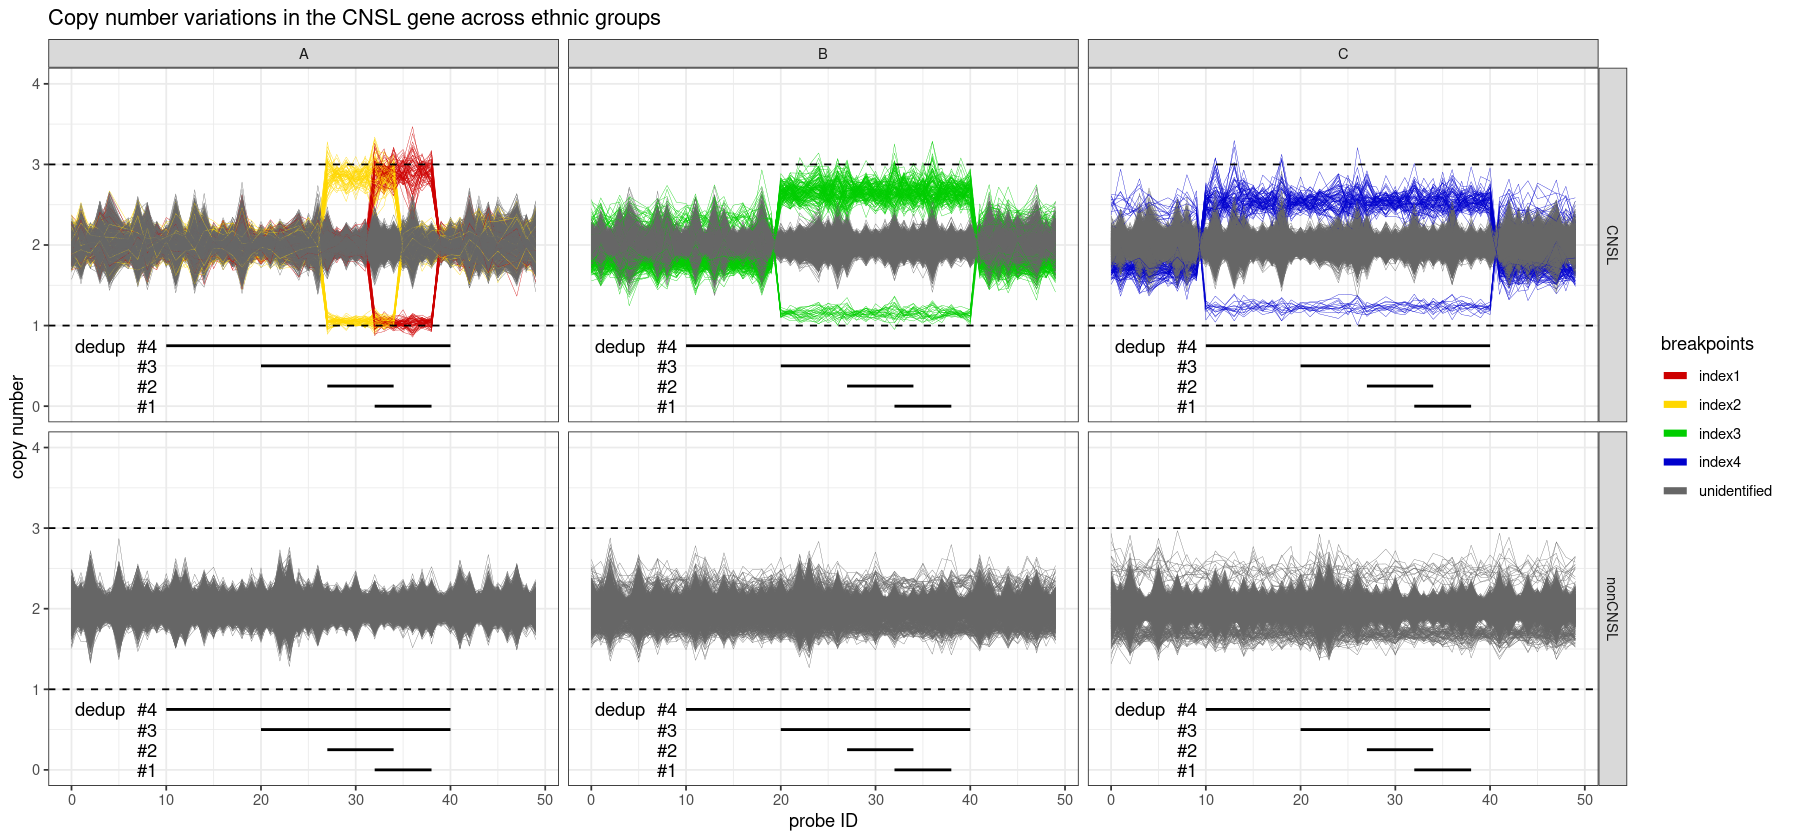

In [11]:
options(warn=-1) 

options(repr.plot.width = 15, repr.plot.height=7)

F1 <- ggplot(CNV_profiles_df, 
       aes(x=probe_number,y=copy_number) ) +
    geom_line(aes(group = patient_id, color=breakpoints), size=0.1) +
    scale_color_manual(values = c("red3","gold", "green3", "blue3", "grey40")) +

    facet_grid(probe_group~ethnicity) +
    coord_cartesian(ylim=c(0,4))+
    theme_bw() +
    labs(title="Copy number variations in the CNSL gene across ethnic groups",
        x = "probe ID", y = "copy number") +

    geom_hline(yintercept=1, linetype="dashed")+
    geom_hline(yintercept=3, linetype="dashed") +

    annotate("segment", x=10, xend=40, y=.75, yend=.75, color="black", size=0.8) +
    annotate("segment", x=20, xend=40, y=.50, yend=.50, color="black", size=0.8) +
    annotate("segment", x=27, xend=34, y=.25, yend=.25, color="black", size=0.8) +
    annotate("segment", x=32, xend=38, y=.00, yend=.00, color="black", size=0.8) +
    annotate(geom="text", label="dedup", color="black", x=3,y=0.75) +
    annotate(geom="text", label="#4", color="black", x=8,y=0.75) +
    annotate(geom="text", label="#3", color="black", x=8,y=0.50) +
    annotate(geom="text", label="#2", color="black", x=8,y=0.25) +
    annotate(geom="text", label="#1", color="black", x=8,y=0.0)

legend_template <- ggplot(CNV_profiles_df, 
       aes(x=probe_number, y=copy_number, color=breakpoints) ) +
    geom_line(size=2) +
    scale_color_manual(values = c("red3","gold", "green3", "blue3", "grey40")) + 
    theme_bw()

cowplot::plot_grid(
  F1 + theme(legend.position = "none"),
  cowplot::get_legend(legend_template),
  nrow = 1, rel_widths = c(10, 1)  )

ggsave("Figure1.pdf", path = './', width=12, height=6, dpi = 200)

**Figure 1. Copy number variations in the CNSL gene indicate conserved 5' and 3' breakpoints associated with Deldupemia.** Copy number of target loci across CNSL and a nonCNSL genes indicate unique copy number variation profiles across ethnic groups. Known probe spanning regions (dedup indices #1-4) are shown in black. Graphs are faceted by ethnicity (A, B, C) and probe group (CNSL and nonCNSL). Line colors correspond to the breakpoint indices identified from the main pipeline, getDeldupIndex(), which relies on statistical variance between patient CNV profiles againts known CNV profiles.

`summarise()` has grouped output by 'ethnicity', 'probe_group', 'breakpoints'.
You can override using the `.groups` argument.


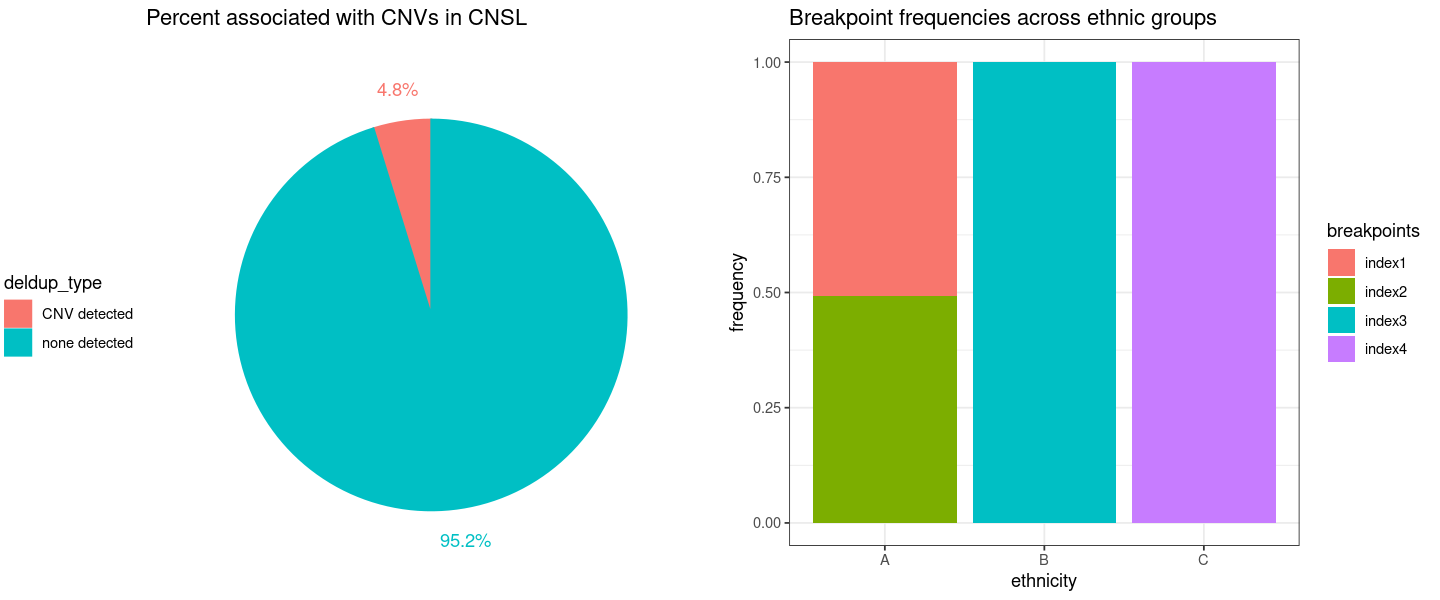

In [12]:
options(repr.plot.width = 12, repr.plot.height=5)

CNV_profiles_df_pie <- CNV_profiles_df %>%
    filter(probe_group=='CNSL') %>%
    distinct(patient_id, .keep_all = TRUE) %>%
    group_by(deldup_type) %>%
    mutate(deldup_type = str_replace(deldup_type, "^del$", "CNV detected"),
           deldup_type = str_replace(deldup_type, "^dup$", "CNV detected"),
           deldup_type = str_replace(deldup_type, "none", "none detected")
          )  %>%  summarize(n=n() )

F2A <- ggplot(CNV_profiles_df_pie, aes(x="", y=n, fill=deldup_type, color=deldup_type)) +
    geom_bar(stat="identity") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(legend.position = 'left') +
    labs(title = "Percent associated with CNVs in CNSL") +

    geom_text(aes(x = 1.6, label = scales::percent((n/sum(CNV_profiles_df_pie$n)), accuracy = .1)), 
            position = position_stack(vjust = .5)) 

CNV_profiles_df_sum <- CNV_profiles_df %>%
    filter(probe_group=='CNSL', breakpoints!= 'unidentified') %>%
    group_by(ethnicity, probe_group, breakpoints, deldup_type) %>%
    summarize(n=n() )

F2B <- ggplot(CNV_profiles_df_sum, aes(x=ethnicity, y=n, fill=breakpoints)) +
    geom_bar(stat="identity", position="fill") + 
    theme_bw() +
    labs(title = "Breakpoint frequencies across ethnic groups", y = "frequency")

plot_grid(F2A, F2B, nrow=1)

ggsave("Figure2.pdf", path = './', width=11, height=4, dpi = 200)

**Figure 2. CNSL breakpoints correlate with ethnicity.** **A.** Pie chart indicating ~5% of patients have a copy number variation in the CNSL gene. **B.** Within ethnic group A, about half of patients encode duplications or deletions at index 1 breakponts and the other half encode CNVs at index 2 breakpoints. Breakpoints identified in ethnic groups B and C match indices 3 and 4, respectively. 

# Algorithm

### Calculating copy number (CN)

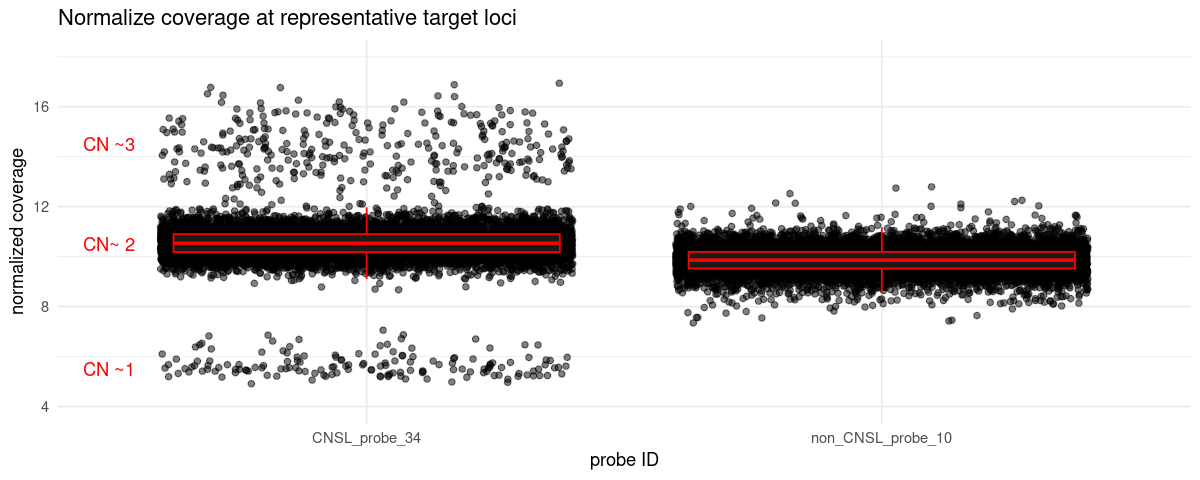

In [13]:
# Representative dataframe - select a few probes for a representative illustration
CNSL_df_0 <- CNSL_df %>% 
    filter(probe_id == "CNSL_probe_34" | probe_id == "non_CNSL_probe_10")

options(repr.plot.width = 10, repr.plot.height=4)

F3 <- ggplot(CNSL_df_0, aes(x=probe_id, y=coverage_per_thousand_reads)) +
    geom_jitter(alpha=0.5) +
    geom_boxplot(outliers=FALSE, color="red", alpha=.1 )+
    theme_minimal() +
    coord_cartesian(ylim=c(4,18))+
    annotate(geom="text", label="CN ~3", color = "red", x=0.5,y=14.5)+
    annotate(geom="text", label="CN ~1", color = "red", x=0.5,y=5.5)+
    annotate(geom="text", label="CN~ 2", color = "red", x=0.5,y=10.5)+

    labs(title="Normalize coverage at representative target loci",
         x = "probe ID", y = "normalized coverage")

F3

ggsave("Figure3.pdf", path = './', width=8, height=4, dpi = 200)

**Figure 3. Strategy for calculating copy number.** CNSL_probe_34 and non_CNSL_probe_10 were chosen for a representative illustration. Coverage at each target loci (probe hybridization loci) was normalized by diving probe coverage by the number of total reads sequenced within each patient ID. After correcting for library size, coverage at each target loci can be compared across patient IDs (but not across probe IDs as capture efficiency varies for each probe). If we assume a linear correlation between normalized coverage and copy number, we can roughly estimate the copy number (CN) of each targeted loci by dividing its coverage by the median coverage (50th percentile coverage across Patient IDs within each probe) and multiplying by 2. That is, if the median coverage is ~10x (CN = 2) then a copy number of 1 and 3 would correspond to a coverage of 5x and 15x, respectively.

### Identifying breakpoints and assigning CNV profiles

My strategy for mapping the boundaries of deletion/duplication events relied on first defining the copy number variation profiles for each known breakpoints combination and comparing the CNV profile for each patient ID to the known CNV profiles. I calculated the variance between each patients CNV profile and all known CNV profiles in the literature (indices 1-4). 

For example, if we are looking for a duplication event consistent with index 1, we know the 5' break point is captured by probe 32 and the 3' break point is captured by probe 38, so we can define the CNV profile for this index. The profile would be stored in a dataframe where the copy number for probes 0-31 and 39-49 would be equal to 2 (CN=2) while the copy number for probes 32-38 would be set equal to 3 (CN=3). The CNV profile for all indices are store in CNV_definitions_df. Printed below is the CNV_definitions_df showing the copy number for CNSL probes 30-40 in a duplication and deletion profiles for index 1. "dup"=duplication and "del"=deletion. 

In [14]:
toy <- CNV_definitions_df %>% filter(probe_number<=40 & probe_number>=30) %>%
    select(probe_number, index1_dup, index1_del)
toy

probe_number,index1_dup,index1_del
<dbl>,<dbl>,<dbl>
30,2,2
31,2,2
32,3,1
33,3,1
34,3,1
35,3,1
36,3,1
37,3,1
38,3,1


For every patient, the copy number at each probe loci was subtracted by the expected copy number for each CNV profile (see table below). For a patient with a CNV profile consistent with a duplication at index 1, we expect a CN=3 at probes 32 through 38 and CN=2 at all other probe loci. For example, if the patient showed a copy number of CN=1.9 at probe 31 and  CN=3.1 at probe 32 (expected CN=2 and CN=3 for duplication at index 1, respectively), the differences list would be 1.9 minus 2 and 3.1 minus 3, or -0.1 and 0.1. A list of difference will be generated for all probes and against all known CNV profiles. 

If the patients CNV profile is consistent with duplication at index 1, the 'differences' list will be populated with near zero values and the variance within that list should be near zero. Variance is the sum of squares of differences between all numbers and means: sum ( (x-mean)^2/n ) where x consists of values in the calculated differences list. The further from 0, the more different the CNV profile is from that to which it is being compared. The *variance of differences* was calculated for each patients CNV profile against all known profiles. The profile for which the *variance of differences* was smallest (and therefore most similar to) was assigned to the patients CNV profile. 

In [15]:
Patient_CN = data.frame(Patient_CN=c(1.8,2.1, 2.9,3.1,3.0,2.8,2.4,2.6,3.2,2.0,1.6))
toy_1 <- cbind(toy, Patient_CN) %>% select(-index1_del) %>%
    rowwise() %>% mutate(difference_to_index1_dup = Patient_CN-index1_dup,
                        difference_to_CN2 = Patient_CN-2)
toy_1

"variance of differences compared to duplication at index 1:"
var(toy_1$difference_to_index1_dup)
"variance of differences compared to CN=2 (no dedup events):"
var(toy_1$difference_to_CN2)

probe_number,index1_dup,Patient_CN,difference_to_index1_dup,difference_to_CN2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30,2,1.8,-0.2,-0.2
31,2,2.1,0.1,0.1
32,3,2.9,-0.1,0.9
33,3,3.1,0.1,1.1
34,3,3.0,0.0,1.0
35,3,2.8,-0.2,0.8
36,3,2.4,-0.6,0.4
37,3,2.6,-0.4,0.6
38,3,3.2,0.2,1.2


[1] "variance of differences compared to duplication at index 1:"

[1] 0.06254545

[1] "variance of differences compared to CN=2 (no dedup events):"

[1] 0.308

The *variance of differences* for the patient's CNV profile indicate it is much more closely related to the CNV profile consistent with index 1 compared to a profile where the copy number = 2 at all probes (shown above) or any other known CNV profile (not shown). **This algorithm takes into account the totality of the patient's CNV profile instead of just looking at the behavior of individual probes in the index spanning regions.**

### Assay Design - Probe performace

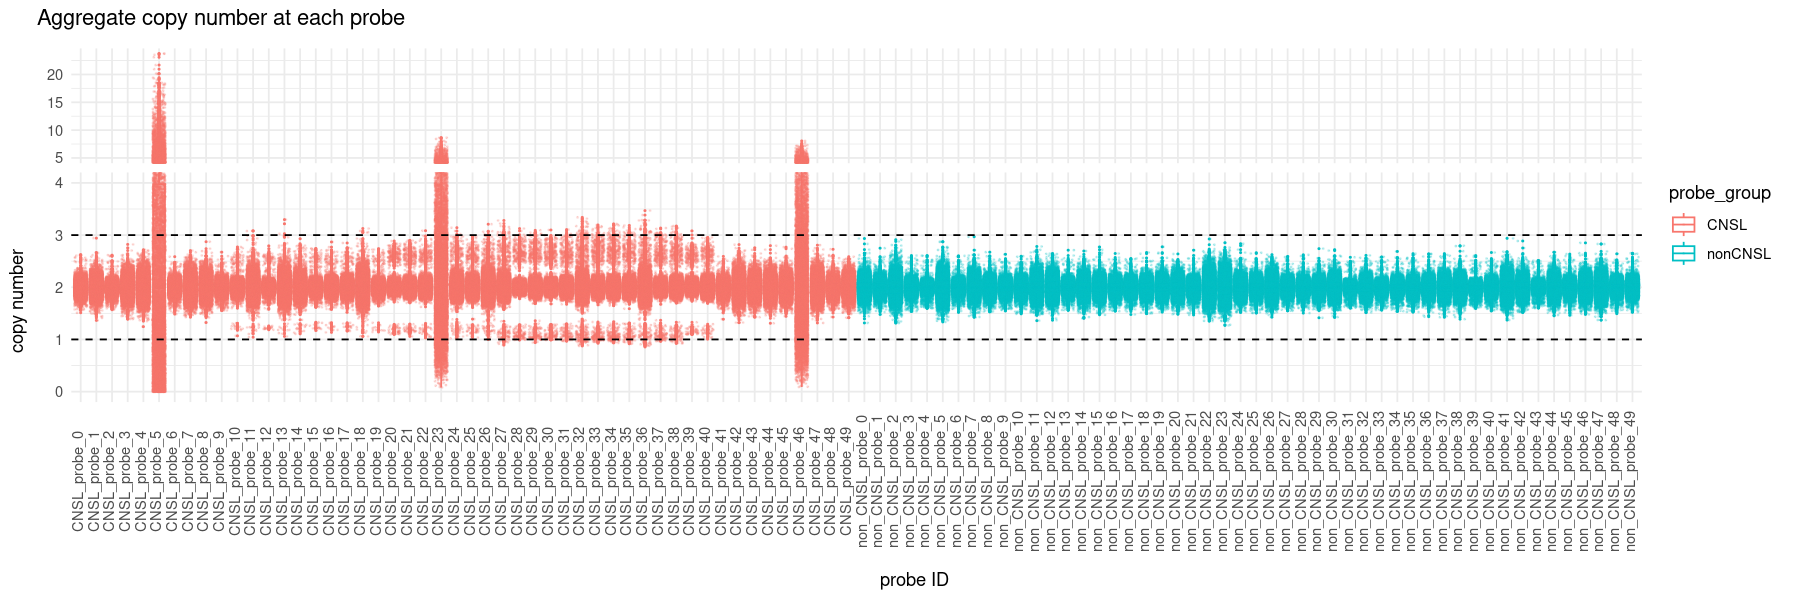

In [16]:
options(repr.plot.width = 15, repr.plot.height=5)

F4 <- ggplot(CNSL_df,  aes(x=probe_id, 
                 y=copy_number, 
                 color = probe_group)) +
    geom_boxplot(outlier.size=.2)+
    geom_jitter(size=.2, alpha=0.2) +
    geom_hline(yintercept=1, color="black", linetype="dashed")+
    geom_hline(yintercept=3, color="black", linetype="dashed")+
    scale_y_break(c(4, 5), scale=.5) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle=90, vjust = 0.2)) +
    labs(title="Aggregate copy number at each probe",
        x = "probe ID", y = "copy number")

F4

ggsave("Figure4.pdf", path = './', width=15, height=5, dpi = 150)

**Figure 4. Copy number of target loci aggregated across patient IDs identify probes that should be eliminated or redesigned.** Since these probes capture DNA from an autosome within a diploid genome, we do not expect any probe to indicate a copy number greater than 3 or less than 1 (dashed lines). Coverage at target loci corresponding to CNSL probes 5, 23, and 46 show increased incidence of greater or lesser than expected copy number, and the distribution of copy number is highly skewed. The data demonstrate that these probes are unreliable for accurate quantitative inference of copy number and should be considered for redesign or elimination from this panel of probes.  